In [1]:
import pickle  # data loading
import gzip  # data loading

import numpy as np  # linear algebra
import matplotlib.pyplot as plt  # plotting

def load_mnist_data():
    """Loads the data, returns training_data, validation_data, test_data."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        return pickle.load(f, encoding='latin1')
    
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist_data()

We have 50000 training images, 10000 validation images and 10000 test images, let's reshape them to 2-dimensional data:

In [2]:
x_train = x_train.reshape((50000, 28, 28))
x_val   = x_val.reshape((10000, 28, 28))
x_test  = x_test.reshape((10000, 28, 28))

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


The pixel values are between 0 and 1:

In [3]:
x_train.min(), x_train.max()

(0.0, 0.99609375)

## Random sampling of digits

The following function creates a set of random sample pixels

In [4]:
def create_sample(n):
     return np.random.randint(28, size=(n, 2))


The activation function sums over the sample pixels in an image

In [5]:
def activation(x, sample):
    return np.sum(x[sample[:,0],sample[:,1]])

Plotting some images and demonstrate activation function:

Activation on 5 is 7.3828125
Activation on 0 is 3.3320312
Activation on 4 is 3.1445312
Activation on 1 is 3.7851562
Activation on 9 is 2.796875
Activation on 2 is 4.8046875
Activation on 1 is 5.2382812
Activation on 3 is 7.1601562
Activation on 1 is 3.7617188
Activation on 4 is 6.3945312


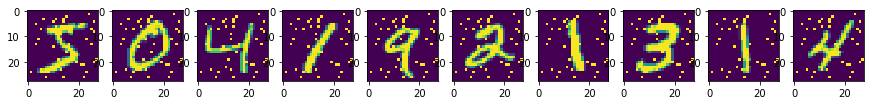

In [6]:
# some sampling points
sample = create_sample(40)

# plot first ten digits
plt.figure(figsize=(15,10))
for i in range(10):
    # highlight sample points in image
    digit = x_train[i]
    digit_with_highlight = digit.copy()
    digit_with_highlight[sample[:,0], sample[:,1]] = 1.0

    # plot digit
    plt.subplot(1,10,i+1)
    plt.imshow(digit_with_highlight)
    
    print("Activation on", str(y_train[i]), "is", activation(digit, sample))

We can see that if we look at the sum over sample pixels, they respond higher on some digits and lower on others. But how stable are these biases?

## Bias of pixel sample sums (called activations here) - means over large groups

To test if this bias of a sum of pixel values (called activation from now on) towards certain digit classes is not just random, first we will calculate the mean activation per digit (a 10-dimensional vector) over a group of digits and then check if these mean activation vectors correlate if we calculate them for different digit sets.

Group training digits (50000) in 10 groups:

In [7]:
# group data and check if bias (digit preference) correlates over groups
num_groups = 10
samples_per_group = 5000

grouped_data = x_train.reshape(num_groups,samples_per_group,28,28)
grouped_classes = y_train.reshape(num_groups,samples_per_group)

print(grouped_data.shape)
print(grouped_classes.shape)

(10, 5000, 28, 28)
(10, 5000)


Helper function: Calculates mean activation per digit on a set of digits:

In [8]:
# xs: digit data of n digits
# ys: digit classes
# sample: set of sample points
def mean_activation_per_digit(xs, ys, sample):
    # number of digits
    n = xs.shape[0]
    assert(n == ys.shape[0])

    scores = np.zeros(10)
    
    # visit all digits
    for i in range(n):
        # calc activation of sample pixels and add them to the sum for the digit class
        scores[ys[i]] += activation(xs[i], sample)
        
    return scores/n


In [9]:
# test mean activations
sample = create_sample(40)

# calc mean activation per digit on first 2 digits
mean_activation1 = mean_activation_per_digit(x_train[0:2], y_train[0:2], sample)

# manual calculation of mean on the first 2 digits as a test
mean_activation2 = (activation(x_train[0], sample) + activation(x_train[1], sample)) / 2

assert(mean_activation1.sum() == mean_activation2)


This code calculates the mean activation vector per group of digits and collects the pairwise correlations between these mean vectors (45 correlations). This is done for 50 different sample sets, resulting in 2250 correlations.

In [10]:
def collect_correlations(pixel_count, num_samples = 50):
    correlations = []

    for k in range(num_samples):
        sample = np.random.randint(28, size=(pixel_count, 2))

        for i in range(num_groups):
            for j in range(i+1, num_groups):
                a = mean_activation_per_digit(grouped_data[i], grouped_classes[i], sample)
                b = mean_activation_per_digit(grouped_data[j], grouped_classes[j], sample)
                correlations.append(np.corrcoef(a,b)[0,1])

    return correlations

pixel_counts = [10, 20, 40, 80]
correlations = list(map(collect_correlations, pixel_counts))


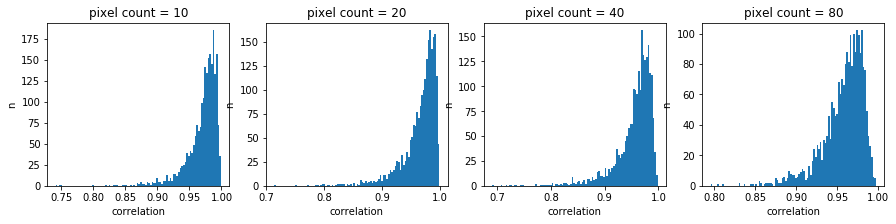

In [11]:
plt.figure(figsize=(15,3))

for i, pixel_count in enumerate(pixel_counts):
    ax = plt.subplot(1,4,i+1)
    ax.set_title("pixel count = "+str(pixel_count))
    ax.hist(correlations[i], bins=100)
    ax.set_xlabel('correlation')
    ax.set_ylabel('n')


## Correlations between activation vectors on 10 single digits (no mean)

Alternatively, here I create 2 sample digit sets, each containing an example for the digit 0, 1, ..., 9 and I calculate the activation vector of a sample pixel set on both digit sets. I then calculate the correlation of these two activations, and I do this for 10000 different pixel samples. The correlations are plotted as a histogram.

In [15]:
# prepare all the indicies for a specific digit class for lookup
indices_by_digit_class = []

for i in range(10):
    indices = np.argwhere(y_train == i)
    indices_by_digit_class.append(indices.reshape(-1))

In [16]:
def collect_correlations2(pixel_count, num_samples = 10000):
    correlations = []
    
    for i in range(num_samples):
        sample = create_sample(pixel_count)

        # create two random digit sets with digits 0, 1, 2, ..., 9
        activations1 = []
        activations2 = []

        for k in range(10):
            # find two random digits of class k
            index1 = np.random.choice(indices_by_digit_class[k])
            index2 = np.random.choice(indices_by_digit_class[k])

            #print(y_train[index1])
            #print(y_train[index2])

            # calculate the activation
            activations1.append(activation(x_train[index1], sample))
            activations2.append(activation(x_train[index2], sample))

        # calc correlation
        c = np.corrcoef(activations1, activations2)[0,1]

        # check: correlation can be nan if both vectors are all 0.0
        if not np.isnan(c):
            correlations.append(c)
            
    return correlations
        
pixel_counts = [10, 20, 40, 80]
correlations = list(map(collect_correlations2, pixel_counts))
    

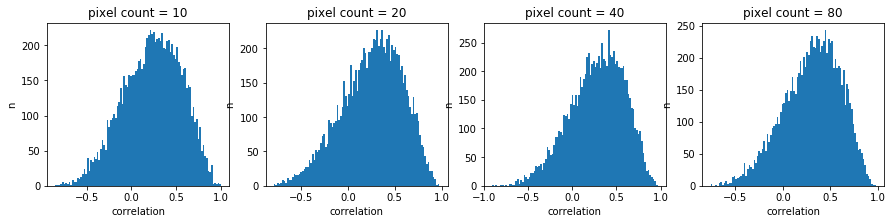

In [17]:
plt.figure(figsize=(15,3))

for i, pixel_count in enumerate(pixel_counts):
    ax = plt.subplot(1,4,i+1)
    ax.set_title("pixel count = "+str(pixel_count))
    ax.hist(correlations[i], bins=100)
    ax.set_xlabel('correlation')
    ax.set_ylabel('n')